In [1]:
import os
import errno

import traceback
import json

import numpy as np

import deepcell
import matplotlib.pyplot as plt

from deepcell.datasets.tracked import hek293,nih_3t3_bench,nih_3t3,hek293_bench,hela_s3_bench,raw2647_bench
from deepcell.datasets.cytoplasm import hela,nih_3t3,cho
from PIL import Image
import imageio
import cv2
import random

import imgaug.augmenters as iaa

import torch
import torchvision.transforms.functional as TF

from skimage import io
import tifffile as tiff

from sklearn.cluster import KMeans

from skimage.transform import resize
import pandas as pd
from deepcell_tracking.trk_io import load_trks

/home/mo/.local/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
2023-07-07 21:21:01.082298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mo/anaconda3/envs/cell/lib/python3.9/site-packages/cv2/../../../../lib:
2023-07-07 21:21:01.082374: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/mo/anaconda3/envs/cell/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mo/anaconda3/envs/cell/lib/python3.9/site-packages/torchvision/image.so: undefined sy

In [2]:
data_dir = '/media/mo/Label/DynamicNuclearNet-tracking-v1_0/'
data = load_trks(os.path.join(data_dir, 'test.trks'))

X = data['X']
y = data['y']
lineages = data['lineages']

data_source = np.load(os.path.join(data_dir, 'data-source.npz'), allow_pickle=True)
meta = pd.DataFrame(data_source['test'], columns=['filename', 'experiment', 'pixel_size', 'screening_passed', 'time_step', 'specimen'])

In [3]:
print(X.shape)
print(lineages.shape)

(12, 71, 584, 600, 1)


AttributeError: 'list' object has no attribute 'shape'

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


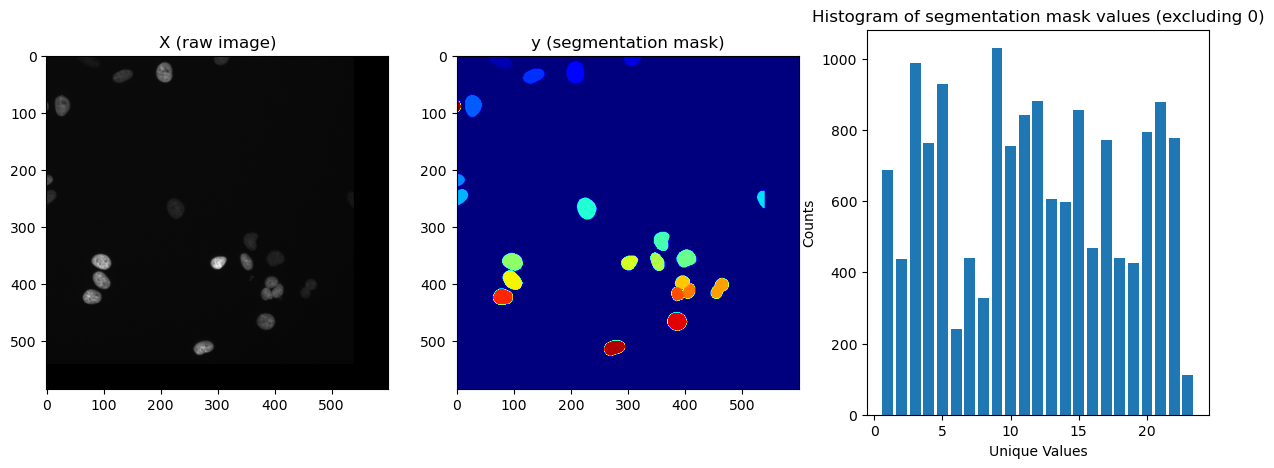

In [7]:
track_id = 0
frame_id = 1

# Load the data
X_frame = X[track_id, frame_id, ..., 0]  # This is assuming channels are last, adjust if necessary
y_frame = y[track_id, frame_id, ..., 0]  # This is assuming channels are last, adjust if necessary
#lineage = lineages[track_id, frame_id, ..., 0]
# Create a figure with two subplots
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the image and label
axes[0].imshow(X_frame, cmap='gray')  # gray scale for raw image
axes[0].set_title('X (raw image)')

axes[1].imshow(y_frame, cmap='jet')  # jet colormap for segmentation mask
axes[1].set_title('y (segmentation mask)')

# Remove the x and y ticks
#for ax in axes:
#    ax.set_xticks([])
#    ax.set_yticks([])

# Find the unique values in the segmentation mask and their counts
unique_values, counts = np.unique(y_frame, return_counts=True)
print(unique_values)
# Exclude zeros
non_zero_indices = unique_values != 0
unique_values = unique_values[non_zero_indices]
counts = counts[non_zero_indices]

# Plot a histogram of the unique values
axes[2].bar(unique_values, counts)
axes[2].set_title('Histogram of segmentation mask values (excluding 0)')
axes[2].set_xlabel('Unique Values')
axes[2].set_ylabel('Counts')

plt.show()
